In [191]:
import importlib
import utils
import transformers
import model
import losses

from sklearn.metrics import mean_squared_error

In [192]:
from model import *
from utils import *

In [193]:
importlib.reload(utils)
importlib.reload(transformers)
importlib.reload(model)
importlib.reload(losses)

<module 'losses' from 'd:\\Documents\\machinelearning\\HybridGlucose\\src\\losses.py'>

In [194]:
print("Current working directory: ", os.getcwd())

Current working directory:  d:\Documents\machinelearning\HybridGlucose\src


In [195]:
raw_dir = "../data/raw"
tuning_dir = "../data/tuning"

In [196]:
assert os.path.exists(raw_dir), "Raw data directory not found"
assert os.path.exists(tuning_dir), "Tuning data directory not found"

In [197]:
dataset = load_data(raw_dir)

Found 22 files in ../data/raw


train (139415, 47)
test (32912, 47)


In [198]:
val_dataset = load_data(tuning_dir)

Found 2 files in ../data/tuning
train (13630, 43)
test (3002, 43)


In [199]:
for key in dataset.keys():
    val_dataset[key] = reduce_classes(val_dataset[key])
    dataset[key] = reduce_classes(dataset[key])

In [200]:
dataset.get("train")['Time'].isnull().sum()

0

In [201]:
train_data = get_train_dataset(dataset['train'])
test_data = get_any_dataset(dataset['test'], dataset['train'])

d:\Documents\machinelearning\HybridGlucose\src\transformers.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["cgm_velo"] = self.calculate_velocity(X)
d:\Documents\machinelearning\HybridGlucose\src\transformers.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['change'] = self.calculate_change(X)
d:\Documents\machinelearning\HybridGlucose\src\transformers.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

      CGM  month  day  hour  minute  weekday  year  wCGM(1)     wCGM(2)  \
30  123.0      5   19    14       5        2  2027    126.0  124.666667   
31  123.0      5   19    14      10        2  2027    123.0  125.000000   
32  124.0      5   19    14      15        2  2027    123.0  123.000000   
33  125.0      5   19    14      20        2  2027    124.0  123.333333   
34  128.0      5   19    14      25        2  2027    125.0  124.333333   

       wCGM(3)  ...     wCGM(5)     wCGM(6)  cgm_velo  change  upper_band  \
30  123.833333  ...  124.933333  126.095238  0.006667     2.0  179.604348   
31  124.500000  ...  123.933333  124.809524 -0.010000    -3.0  171.672273   
32  124.500000  ...  123.866667  123.904762  0.000000     0.0  163.328233   
33  123.166667  ...  124.200000  123.857143  0.003333     1.0  156.865242   
34  123.666667  ...  124.266667  124.190476  0.003333     1.0  151.762371   

    lower_band  extreme_CGM_80  extreme_CGM_85  extreme_CGM_90  extreme_CGM_95  
30   

d:\Documents\machinelearning\HybridGlucose\src\transformers.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["cgm_velo"] = self.calculate_velocity(X)
d:\Documents\machinelearning\HybridGlucose\src\transformers.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['change'] = self.calculate_change(X)
d:\Documents\machinelearning\HybridGlucose\src\transformers.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [202]:
train_data.head()

,CGM,month,day,hour,minute,weekday,year,wCGM(1),wCGM(2),wCGM(3),...,wCGM(5),wCGM(6),cgm_velo,change,upper_band,lower_band,extreme_CGM_80,extreme_CGM_85,extreme_CGM_90,extreme_CGM_95
30,123.0,5,19,14,5,2,2027,126.0,124.666667,123.833333,...,124.933333,126.095238,0.006667,2.0,179.604348,64.395652,0,0,0,0
31,123.0,5,19,14,10,2,2027,123.0,125.000000,124.500000,...,123.933333,124.809524,-0.010000,-3.0,171.672273,76.661061,0,0,0,0
32,124.0,5,19,14,15,2,2027,123.0,123.000000,124.500000,...,123.866667,123.904762,0.000000,0.0,163.328233,88.755100,0,0,0,0
33,125.0,5,19,14,20,2,2027,124.0,123.333333,123.166667,...,124.200000,123.857143,0.003333,1.0,156.865242,98.051424,0,0,0,0
34,128.0,5,19,14,25,2,2027,125.0,124.333333,123.666667,...,124.266667,124.190476,0.003333,1.0,151.762371,105.320963,0,0,0,0


The tuning data will be merged with the training data and be fitted into the pipeline to be used for the validation data

In [203]:
tuning_data = get_tuning_dataset(val_dataset['train'], dataset['train'])
val_data = get_any_dataset(val_dataset['test'], tuning_data)

d:\Documents\machinelearning\HybridGlucose\src\transformers.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["cgm_velo"] = self.calculate_velocity(X)
d:\Documents\machinelearning\HybridGlucose\src\transformers.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['change'] = self.calculate_change(X)
d:\Documents\machinelearning\HybridGlucose\src\transformers.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [204]:
trainX, trainY = train_data.drop(["CGM"], axis = 1), train_data["CGM"]
trainX.shape, trainY.shape

((123673, 20), (123673,))

In [205]:
testX, testY = test_data.drop(["CGM"], axis = 1), test_data["CGM"]
testX.shape, testY.shape

((28431, 20), (28431,))

In [206]:
testX.tail(5)

,month,day,hour,minute,weekday,year,wCGM(1),wCGM(2),wCGM(3),wCGM(4),wCGM(5),wCGM(6),cgm_velo,change,upper_band,lower_band,extreme_CGM_80,extreme_CGM_85,extreme_CGM_90,extreme_CGM_95
32907,1,23,20,55,6,2022,150.0,151.333333,152.666667,154.0,155.666667,156.619048,-0.006667,-2.0,231.007617,121.742383,0,0,0,0
32908,1,23,21,0,6,2022,149.0,149.666667,150.833333,152.1,153.400000,155.000000,-0.003333,-1.0,226.195461,121.387873,0,0,0,0
32909,1,23,21,5,6,2022,148.0,148.666667,149.333333,150.4,151.600000,152.857143,-0.003333,-1.0,221.190096,121.393237,0,0,0,0
32910,1,23,21,10,6,2022,151.0,149.000000,149.000000,149.4,150.266667,151.333333,0.010000,3.0,217.096903,121.403097,0,0,0,0
32911,1,23,21,15,6,2022,149.0,150.333333,149.166667,149.1,149.400000,150.142857,-0.006667,-2.0,213.194437,121.305563,0,0,0,0


In [207]:
model = HybridModel()
model.fit(trainX, trainY, testX, testY, eval = True, tune = False)

Base fitted with columns: Index(['month', 'day', 'hour', 'minute', 'weekday', 'year', 'wCGM(1)',
       'wCGM(2)', 'wCGM(3)', 'wCGM(4)', 'wCGM(5)', 'wCGM(6)', 'cgm_velo',
       'change', 'upper_band', 'lower_band', 'extreme_CGM_80',
       'extreme_CGM_85', 'extreme_CGM_90', 'extreme_CGM_95', 'direction'],
      dtype='object')
Base: (16.228380608088347, 4.028446426116195, 0.0759217750728842)
Base + Residuals: (16.13979952734394, 4.0174369350798695, 0.07555821840938529) Change: 3.7551527076009847%


In [208]:
def plot_forecast(X, y, model, n_steps = 12, lookback = 0, use_confi = True, navigator_weight = 1, show_median = False, plot = True):
    if len(X.shape) == 1 or X.shape[1] == 0:
        raise ValueError("Input data must be 2 dimensional and non empty.")
    
    if len(X) != len(y):
        raise ValueError("Input data and output data must have the same length.")
    
    if X.shape[0] > n_steps:
        result = model.forecast(X.iloc[:-n_steps], n_steps = n_steps, return_X = False, use_confi = use_confi, navigator_weight = navigator_weight * 100)
        forecast = result["forecasts"]
        actual = y.iloc[-n_steps - lookback:].reset_index(drop = True)
    else:
        result = model.forecast(X, n_steps = n_steps, return_X = False, use_confi = use_confi, navigator_weight = navigator_weight)
        forecast = result["forecasts"]
        actual = y.iloc[-n_steps - lookback:].reset_index(drop = True)
    
    if plot:
        plt.figure(figsize = (15, 5))
        plt.title('Forecast vs Actual', fontsize=20)
        plt.xlabel('Iterations', fontsize=15)
        plt.ylabel('Glucose', fontsize=15)
        plt.grid(True)
        
        if use_confi:
            confi_int = result["confi_forecasts"]
            if show_median:
                plt.plot(np.arange(lookback, len(forecast) + lookback), confi_int['Median'], label = "Median", color = "black", linestyle='--', linewidth=2)
            plt.fill_between(np.arange(lookback, len(forecast) + lookback), confi_int["Lower"], confi_int["Upper"], color = "black", alpha = 0.15)

        plt.plot(actual, label = "Actual", color = "blue", linewidth=2)
        plt.plot(np.arange(lookback, len(forecast) + lookback), forecast, label = "Forecast", color = "green", linestyle='-', linewidth=2)
        
        plt.legend(fontsize=12)
        plt.show()
    
    rmse = np.sqrt(mean_squared_error(actual.iloc[lookback:], forecast))
    return rmse

In [224]:
def evaluate(X, y, model, n_steps = 12, navigator_weight = 1, n_iter = 10, lookback = 12):
    rmses = []
    print("Evaluating with weights =", navigator_weight)
    for i in tqdm(range(n_iter)):
        start_idx = np.random.randint(0, len(X) - n_steps - lookback)
        X_sample = X[start_idx: start_idx + lookback + n_steps]
        y_sample = y[start_idx: start_idx + lookback + n_steps]
        print(X_sample.shape)
        rmse = plot_forecast(X_sample, y_sample, model, lookback = lookback, n_steps = n_steps, navigator_weight = navigator_weight, use_confi = True, plot = True)
        rmses.append(rmse)
    return np.mean(rmses)

In [225]:
def find_best_navigator_weight(X, y, model, n_steps = 12, n_iter = 5):
    best_rmse = float('inf')
    best_navigator_weight = None
    for navigator_weight in range(-64, 64):
        rmses = []
        for i in range(n_iter):
            start_idx = np.random.randint(0, len(X) - n_steps)
            X_sample = X[start_idx : start_idx + n_steps]
            y_sample = y[start_idx : start_idx + n_steps]
            rmse = plot_forecast(X_sample, y_sample, model, n_steps = n_steps, navigator_weight = navigator_weight, use_confi = False, plot = False)
            rmses.append(rmse)
        mean_rmse = np.mean(rmses)
        if mean_rmse < best_rmse:
            best_rmse = mean_rmse
            best_navigator_weight = navigator_weight
    return best_navigator_weight, best_rmse

Evaluating with weights = 2


  0%|          | 0/5 [00:00<?, ?it/s]

(24, 21)


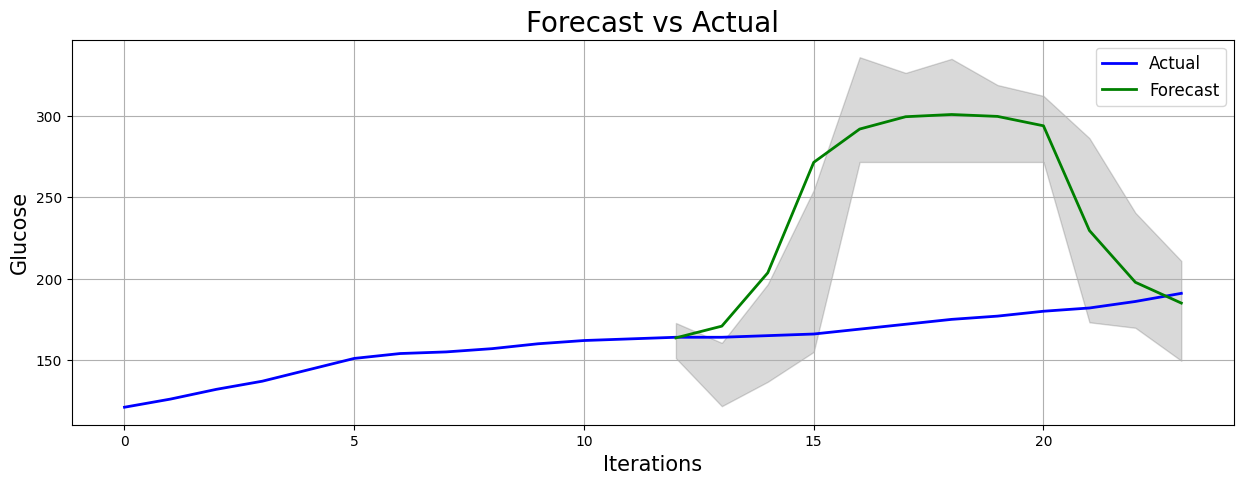

 20%|██        | 1/5 [00:00<00:01,  2.28it/s]

(24, 21)


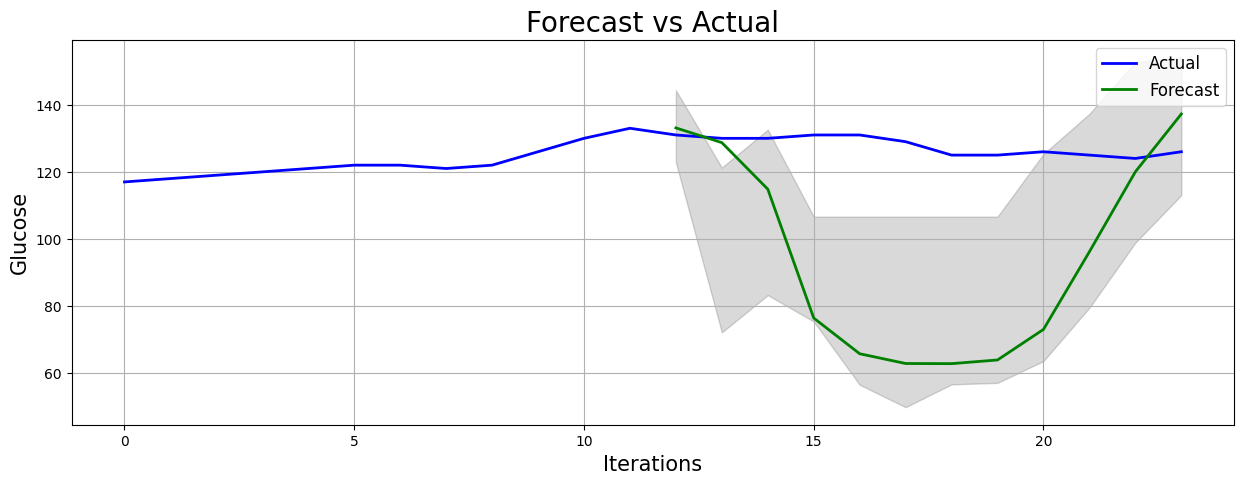

 40%|████      | 2/5 [00:00<00:01,  2.19it/s]

(24, 21)


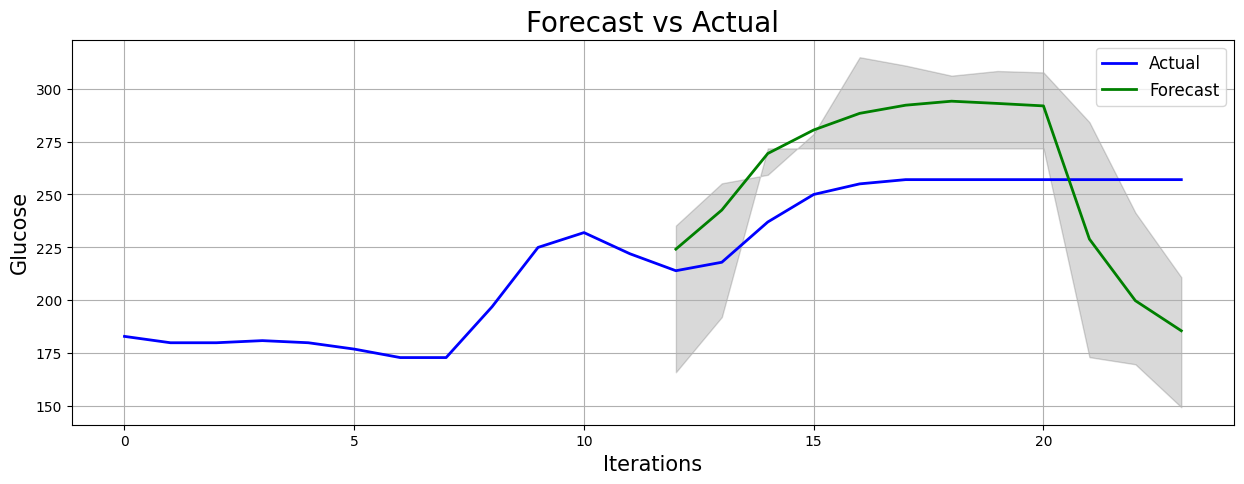

 60%|██████    | 3/5 [00:01<00:01,  1.78it/s]

(24, 21)


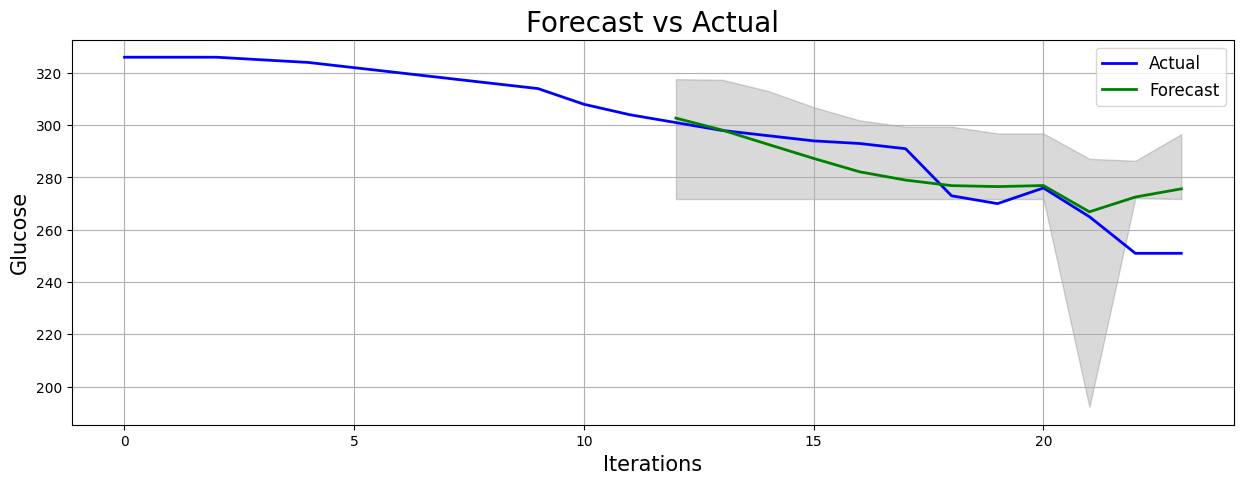

 80%|████████  | 4/5 [00:02<00:00,  1.95it/s]

(24, 21)


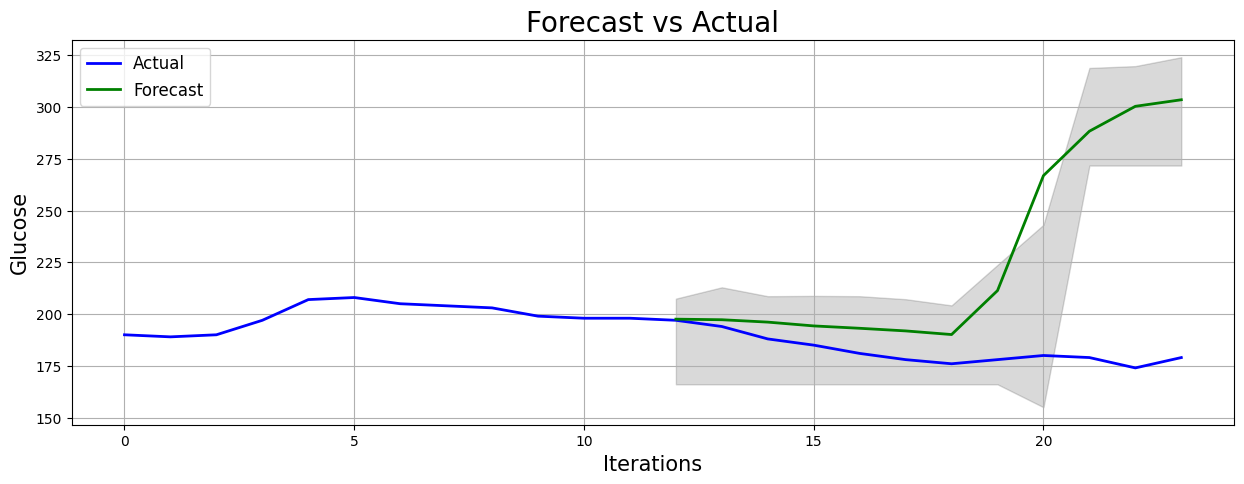

100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


49.38423905881643

In [231]:
evaluate(testX, testY, model, navigator_weight = 2, n_iter = 5)